# The moments of the distribution for protein in a two- and three-state promoter.

(c) 2017 Manuel Razo. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT)

In [1]:
import glob
import pickle
# Our numerical workhorses
import numpy as np
# To compute symbolic expressions
import sympy
sympy.init_printing(use_unicode=True, use_latex=True) # print outputs in LaTeX

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

# Seaborn, useful for graphics
import seaborn as sns

# Import the utils for this project
import chann_cap_utils as chann_cap

# Set PBoC plotting style
# chann_cap.set_plotting_style()

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline (only use with static plots (non-Bokeh))
%config InlineBackend.figure_format = 'svg'

# figdir = '../../fig/chemical_master_analytic_mRNA/'
tmpdir = '../../tmp/'

### $\LaTeX$ macros
$\newcommand{kpon}{k^p_{\text{on}}}$
$\newcommand{kpoff}{k^p_{\text{off}}}$
$\newcommand{kron}{k^r_{\text{on}}}$
$\newcommand{kroff}{k^r_{\text{off}}}$
$\newcommand{rm}{r _m}$
$\newcommand{gm}{\gamma _m}$
$\newcommand{mm}{\left\langle m \right\rangle}$

# Two-state promoter (protein)

In this section we will perform the linear algebra to solve for the steady-state moments of the mRNA distribution.

Up to this stage we wrote the chemical master equation in matrix notation and did some tricks when it came to compute the $n^{\text{th}}$ moment. Now we will use the equations we obtained for the time derivative of the mRNA distribution moments and set that to steady-state to solve for the moments themselves.

Let's first define the `sympy` variables that we will need for the two- and three-state promoter.

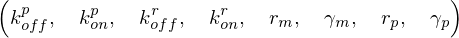

In [2]:
# Define rate constant variables
kp_off, kp_on = sympy.symbols('{k_{off}^p} {k_{on}^p}')
kr_off, kr_on = sympy.symbols('{k_{off}^r} {k_{on}^r}')

# Define degradation rate and production rate
rm, gm = sympy.symbols('r_m gamma_m')
rp, gp = sympy.symbols('r_p gamma_p')

kp_off, kp_on, kr_off, kr_on, rm, gm, rp, gp

Let's now define a function that generates a `sympy` variable of the form $\left\langle x^n \right\rangle$ to easily define the variables to save the moments.

In [3]:
def moment_sympy(var, moment):
    '''
    Shortcut to generate variables of the form <var**n> in sympy to facilitate the
    definition of the moment variables
    Parameters
    ----------
    var : string.
        variable name string that should be put inside the <> parenthesis.
    moment : int.
        exponent of the moment to be defined.
    '''
    if moment == None:
        return sympy.Symbol('{\\langle ' + var + '\\rangle}')
    else:
        return sympy.Symbol('{\\langle ' + var + '^{:d}'.format(moment) +\
                            '\\rangle}')

Now let's define the moment variables for the unregulated promoter. We will do it for both the mRNA and the protein since the protein moments depend also on mRNA moments.

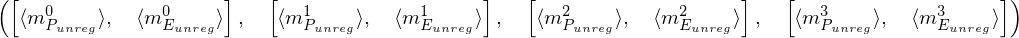

In [4]:
# Define the string for the states
m_unreg = ['m_{P_{unreg}}', 'm_{E_{unreg}}']

# Define the zeroth moments
m0_unreg = [moment_sympy(x, 0) for x in m_unreg]
# Define the first moments
m1_unreg = [moment_sympy(x, 1) for x in m_unreg]
# Define the second moments
m2_unreg = [moment_sympy(x, 2) for x in m_unreg]
# Define the second moments
m3_unreg = [moment_sympy(x, 3) for x in m_unreg]

m0_unreg, m1_unreg, m2_unreg, m3_unreg

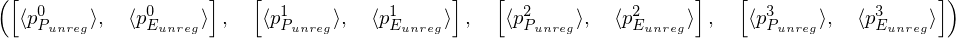

In [5]:
# Define the string for the states
p_unreg = ['p_{P_{unreg}}', 'p_{E_{unreg}}']

# Define the zeroth moments
p0_unreg = [moment_sympy(x, 0) for x in p_unreg]
# Define the first moments
p1_unreg = [moment_sympy(x, 1) for x in p_unreg]
# Define the second moments
p2_unreg = [moment_sympy(x, 2) for x in p_unreg]
# Define the second moments
p3_unreg = [moment_sympy(x, 3) for x in p_unreg]

p0_unreg, p1_unreg, p2_unreg, p3_unreg

In [99]:
# define "global" moments
mm0_unreg = moment_sympy('\mathbf{m}_u', 0)
mm1_unreg = moment_sympy('\mathbf{m}_u', None)
mm2_unreg = moment_sympy('\mathbf{m}_u', 2)
pp0_unreg = moment_sympy('\mathbf{p}_u', 0)
pp1_unreg = moment_sympy('\mathbf{p}_u', None)
pp2_unreg = moment_sympy('\mathbf{p}_u', 2)
mmpp_unreg = moment_sympy('\mathbf{mp}_u', None)
mm0_unreg, mm1_unreg, mm2_unreg, pp0_unreg, pp1_unreg, pp2_unreg, mmpp_unreg

Now we will define the state transition matrix $\mathbf{K}^u$, the mRNA production matrix $\mathbf{R}^u_m$ and the mRNA degradation matrix $\mathbf{\Gamma}^u_m$.

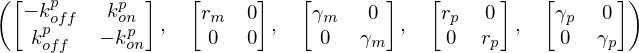

In [7]:
# Define the rate constant matrix
Km_unreg = sympy.Matrix([[-kp_off, kp_on], 
                           [kp_off, -kp_on]])
# Define the mRNA production matrix
Rm_unreg = sympy.Matrix([[rm, 0], 
                         [0, 0]])
# Define the mRNA degradation matrix
Gm_unreg = sympy.Matrix([[gm, 0],
                         [0, gm]])

# Define the protein production matrix
Rp_unreg = sympy.Matrix([[rp, 0], 
                         [0, rp]])
# Define the protein degradation matrix
Gp_unreg = sympy.Matrix([[gp, 0],
                         [0, gp]])


Km_unreg, Rm_unreg, Gm_unreg, Rp_unreg, Gp_unreg

### Import mRNA moments
Let's import the solutions we obtained for the mRNA moments that are saved in a `pickle` object.

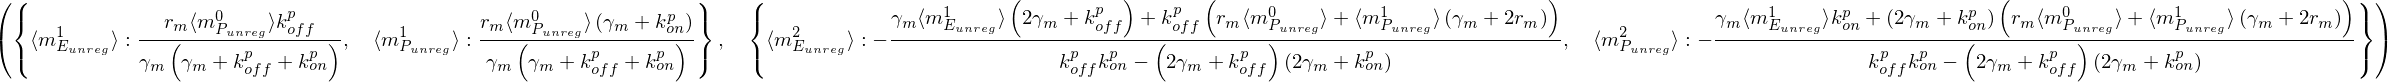

In [100]:
with open(tmpdir + 'two_state_mRNA_solutions.pkl', 'rb') as file:
    first_sol_unreg_m = pickle.load(file)
    second_sol_unreg_m = pickle.load(file)
    third_sol_unreg_m = pickle.load(file)

first_sol_unreg_m, second_sol_unreg_m

We now import the expressions of the moments in termos of the global moments

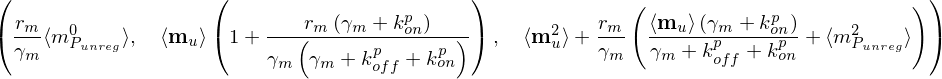

In [102]:
with open(tmpdir + 'two_state_mRNA_moments.pkl', 'rb') as file:
    first_unreg_moments_m = pickle.load(file)
    second_unreg_moments_m = pickle.load(file)
    third_unreg_moments_m = pickle.load(file)

first_unreg_moments_m, second_unreg_moments_m, third_unreg_moments_m

### Zeroth moment two-state promoter
In order to solve for the two-state promoter we have two equations to use
$$
1 = \mathbf{u} \cdot \left\langle \mathbf{m}^0 \right\rangle,
$$
where $u = (1, 1)$ and $\left\langle \mathbf{m}^0 \right\rangle$ is the vector containing all the states, and
$$
\mathbf{0} = \mathbf{K}^u_m \left\langle \mathbf{m}^0 \right\rangle.
$$

We will use the linear algebra solver where we write an extended matrix with the last column being the right hand side of these equations.

Let's now define this extended matrix.

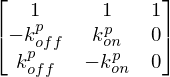

In [103]:
# Add the extra row for the normalization constraint
K_sys_unreg = Km_unreg.row_insert(0, sympy.Matrix([1, 1]).transpose())

# Define right-side array
b = sympy.Matrix([1, 0, 0])

# Define augmented matrix
zero_aug_unreg = K_sys_unreg.col_insert(2, b)
zero_aug_unreg

Now we solve the equation for the two state moments.

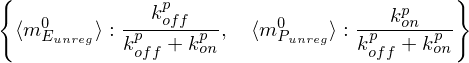

In [104]:
# Solve linear system for the three zeroth moments
zero_sol_unreg = sympy.solve_linear_system(zero_aug_unreg, *m0_unreg)
zero_sol_unreg

### First moment two-state promoter (protein)

Now that we have the zeroth moment that indicates the probability of being on either state let's now compute the first moment. For this we have the matrix equation
$$
\mathbf{0} = \left( \mathbf{K}^u - \mathbf{\Gamma}^u_p  \right)
             + \mathbf{R}^u_p \left\langle \mathbf{m} \right\rangle.
$$

Let's write this system in the form of the augmented matrix.

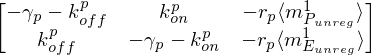

In [105]:
# Define augmented matrix for first moment
first_aug_unreg = (Km_unreg - Gp_unreg).col_insert(2, 
                                            -Rp_unreg * sympy.Matrix(m1_unreg))
first_aug_unreg

And again we use the `sympy` solver to solve for the first moments

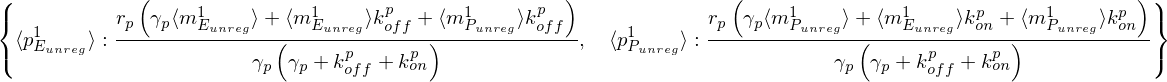

In [106]:
# Solve linear system for the first protein moments
first_sol_unreg_p = sympy.solve_linear_system(first_aug_unreg, *p1_unreg)
first_sol_unreg_p

We now sum both elements and substitute the solution for the zeroth moments

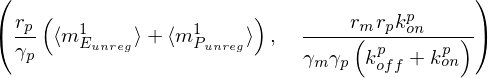

In [107]:
# Sum the results for the first moments
first_unreg_p = sum(first_sol_unreg_p.values()).simplify()
# Substitute the solutions for the mRNA first and zeroth moment
first_unreg_p_s = first_unreg_p.subs(first_sol_unreg_m).\
                            subs(zero_sol_unreg).simplify()
# Display solution in terms of the mRNA global first moment
first_unreg_p,\
first_unreg_p_s # Disiplay substituted solution.

Let's display the solution for the first moment in terms of the global moments

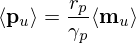

In [108]:
first_unreg_moments_p = first_unreg_p.subs(sum(m1_unreg), mm1_unreg)
sympy.Eq(pp1_unreg, first_unreg_moments_p)

### mRNA-protein correlation two-state promoter

The computation of the second moment $\left\langle \mathbf{p}^2 \right\rangle$ depends on the correlation $\left\langle \mathbf{mp} \right\rangle$. To compute this correlation we have the equation
$$
\mathbf{0} = \left( \mathbf{K}^u - \mathbf{\Gamma}^u_m -  \mathbf{\Gamma}^u_p  \right)
             \left\langle \mathbf{mp} \right\rangle 
             + \mathbf{R}^u_m \left\langle \mathbf{p} \right\rangle
             + \mathbf{R}^u_p \left\langle \mathbf{m}^2 \right\rangle
$$
Let's define this augmented matrix.

In [109]:
# Define the string for the states
corr_unreg = ['mp_{P_{unreg}}', 'mp_{E_{unreg}}']

# Define the zeroth moments
mp_unreg = [moment_sympy(x, None) for x in corr_unreg]
mp_unreg

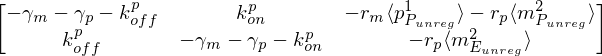

In [110]:
# define augmented matrix for correlation
corr_aug_unreg = (Km_unreg - Gm_unreg - Gp_unreg).col_insert(2,
                  - Rm_unreg * sympy.Matrix(p1_unreg)\
                  - Rp_unreg * sympy.Matrix(m2_unreg))
corr_aug_unreg

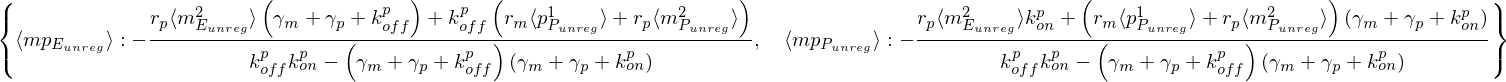

In [111]:
# Solve linear system for the three moments
corr_sol_unreg = sympy.solve_linear_system(corr_aug_unreg, *mp_unreg)
corr_sol_unreg

The sum of these terms gives the correlation we are looking for.

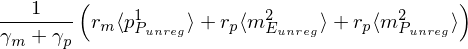

In [112]:
# Sum the terms of the correlation
corr_unreg = sum(corr_sol_unreg.values()).simplify()
# Substitutte relevant solutions
corr_unreg_s = corr_unreg.subs(first_sol_unreg_p).subs(second_sol_unreg_m).\
               subs(first_sol_unreg_m).subs(zero_sol_unreg)
    
# Display solution without substitutions
corr_unreg

We now display the solution in terms of the global moments.

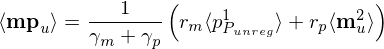

In [113]:
# Display correlation as a functiono f the second mRNA moment
corr_moments = corr_unreg.collect(rp).subs(sum(m2_unreg), mm2_unreg)
sympy.Eq(mmpp_unreg, corr_moments)

LEt's implement the approximation of $\gm \gg \gamma_p$. This would give us

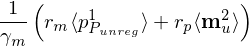

In [114]:
corr_moments_approx = corr_moments.subs(gm + gp, gm)
corr_moments_approx

### Second moment two-state promoter

For the second moment we have an equation of the form
$$
\mathbf{0} = \left( \mathbf{K}^u - 2 \mathbf{\Gamma}^u_p \right) 
             \left\langle \mathbf{p}^2 \right\rangle
             + \mathbf{\Gamma}^u_p \left\langle \mathbf{p} \right\rangle
             + \mathbf{R}^u_p \mm
             + 2 \mathbf{R}^u_p \left\langle \mathbf{mp} \right\rangle
$$

Let's again define this augmented matrix.

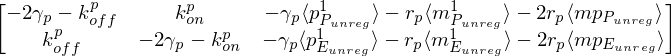

In [115]:
# Define augmented matrix for second moment
second_aug_unreg = (Km_unreg - 2 * Gp_unreg).col_insert(2, 
                    - Gp_unreg * sympy.Matrix(p1_unreg)\
                    - Rp_unreg * sympy.Matrix(m1_unreg)\
                    - 2 * Rp_unreg * sympy.Matrix(mp_unreg))
second_aug_unreg

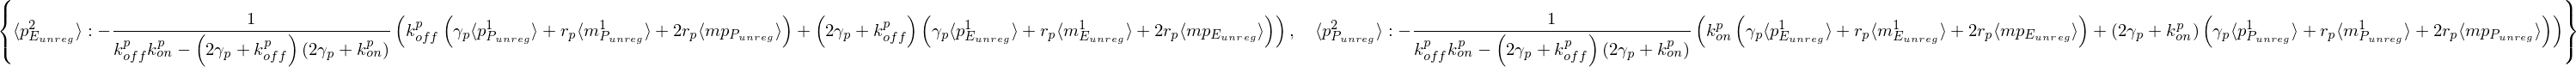

In [116]:
# Solve linear system for the three moments
second_sol_unreg_p = sympy.solve_linear_system(second_aug_unreg, *p2_unreg)
second_sol_unreg_p

Again let's add both of these moments to obtain the global second moment.

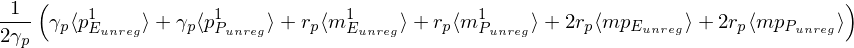

In [117]:
# Sum the soltuon of second moments
second_unreg_p = sum(second_sol_unreg_p.values()).simplify()
# Substitute relevant solutions
second_unreg_s = second_unreg_p.subs(corr_sol_unreg).subs(first_sol_unreg_p).\
                 subs(second_sol_unreg_m).subs(first_sol_unreg_m).\
                 subs(zero_sol_unreg)

# Display solution without substitutions
second_unreg_p

Again let's show the solution using the global moments.

The complexity of the substitutions comes from step-by-step manually recognizing patterns.

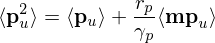

In [118]:
# Display solution
second_unreg_moments_p = second_unreg_p.\
            collect(gp).collect(rp).\
            subs(sum(p1_unreg), pp1_unreg).\
            subs(sum(m1_unreg), mm1_unreg).\
            subs(sum(2 * mp_unreg), 2 * mmpp_unreg).\
            expand().\
            subs(rp / (2 * gp) * mm1_unreg, pp1_unreg / 2)
sympy.Eq(pp2_unreg,  second_unreg_moments_p)

Using the solution for $\left\langle \mathbf{mp} \right\rangle$ with the $\gm \gg \gamma_p$ approximation gives

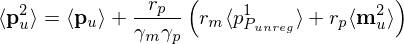

In [119]:
second_unreg_moments_approx = second_unreg_moments_p.\
                              subs(mmpp_unreg, corr_moments_approx).\
                              collect(rp / (gm * gp))

sympy.Eq(pp2_unreg, second_unreg_moments_approx)

### Noise $\eta$ and fano-factor

Having the first and second moment let's compute the variance and the fano-factor to compare it with the results from Sharehzaei and Swain.

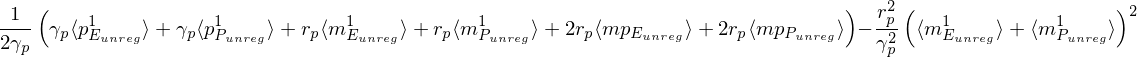

In [120]:
# Compute the variance of the unregulated promoter
var_unreg_p = second_unreg_p - first_unreg_p**2
var_unreg_p_s = var_unreg_p.subs(corr_sol_unreg).\
                            subs(first_sol_unreg_p).\
                            subs(second_sol_unreg_m).\
                            subs(first_sol_unreg_m).\
                            subs(zero_sol_unreg)
var_unreg_p

We again simplify this solution as a function of global moments.

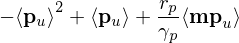

In [121]:
var_unreg_moments_p = second_unreg_moments_p - pp1_unreg**2
var_unreg_moments_p

Or using the approximate solution for $\left\langle \mathbf{mp} \right\rangle$

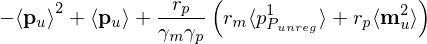

In [122]:
var_unreg_moments_approx = second_unreg_moments_approx - pp1_unreg**2
var_unreg_moments_approx

#### Fano-factor
We now turn to computing the **fano-factor**.

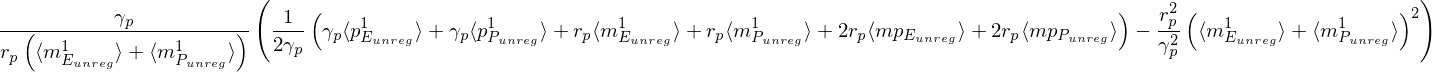

In [123]:
# Compute the fano factor of the unregulated promoter
fano_unreg_p = var_unreg_p / first_unreg_p
fano_unreg_s = fano_unreg_p.subs(corr_sol_unreg).\
                          subs(first_sol_unreg_p).\
                          subs(second_sol_unreg_m).\
                          subs(first_sol_unreg_m).\
                          subs(zero_sol_unreg)
fano_unreg_p

Again it is more clear to display this equation as a funciton of global moments.

The complexity of the substitutions comes from step-by-step recognizing parmeters in the equation.

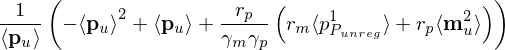

In [124]:
fano_unreg_moments_p = var_unreg_moments_approx / pp1_unreg 

fano_unreg_moments_p

#### Noise

Let's now compute the noise squared 
$$
\eta^2 = {\sigma_p^2 \over \left\langle \mathbf{p} \right\rangle^2}
$$

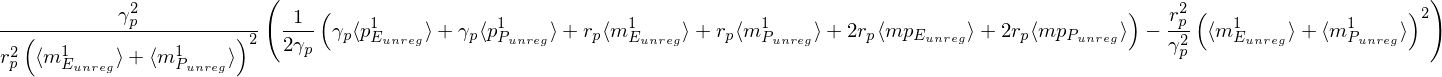

In [125]:
# Compute the fano factor of the unregulated promoter
noise_square_unreg_p = var_unreg_p / first_unreg_p**2
noise_square_unreg_p_s = noise_square_unreg_p.subs(corr_sol_unreg).\
                          subs(first_sol_unreg_p).\
                          subs(second_sol_unreg_m).\
                          subs(first_sol_unreg_m).\
                          subs(zero_sol_unreg)
noise_square_unreg_p

And again we substitute the global moments to display a more transparent expression.

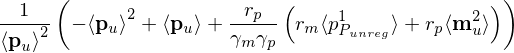

In [126]:
noise_square_unreg_moments = (var_unreg_moments_approx / pp1_unreg**2)
noise_square_unreg_moments

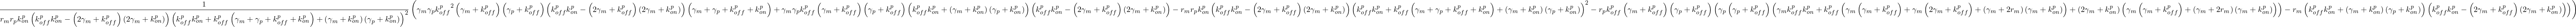

In [127]:
noise_square_unreg_moments.subs(first_sol_unreg_p).\
                           subs(mm2_unreg, sum(m2_unreg)).\
                           subs(pp1_unreg, sum(p1_unreg)).\
                           subs(first_sol_unreg_p).\
                           subs(second_sol_unreg_m).\
                           subs(first_sol_unreg_m).\
                           subs(zero_sol_unreg).\
                           subs(kp_off + kp_on, kp_off).\
                           subs(gm + gp , gm).simplify()

Let's compare this result to the one derived by Shahrezaei and Swain.

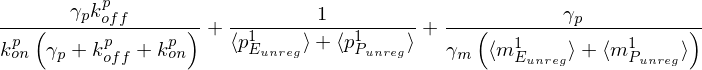

In [128]:
# Define noise as derived by Shahrezaei and Swain
noise_square_swain = 1 / (sum(p1_unreg)) +\
                     gp / gm * 1 / sum(m1_unreg) +\
                     gp / (gp + kp_off + kp_on) * kp_off / kp_on
noise_square_swain_s = noise_square_swain.subs(first_sol_unreg_p).\
                                          subs(first_sol_unreg_m).\
                                          subs(zero_sol_unreg)
noise_square_swain

# Three-state promoter (mRNA)

Let's now derive the moments for the three-state promoter. The matrix equations remain the same between the two- and the three-state promoter. The only difference is the definition of the state transition, production and degradation matrix.

Let's first define the moment variables

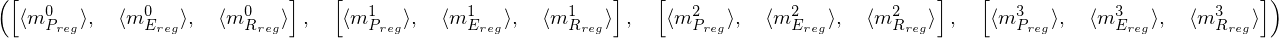

In [129]:
# Define the string for the states
m_reg = ['m_{P_{reg}}', 'm_{E_{reg}}', 'm_{R_{reg}}']

# Define the zeroth moments
m0_reg = [moment_sympy(x, 0) for x in m_reg]
# Define the first moments
m1_reg = [moment_sympy(x, 1) for x in m_reg]
# Define the second moments
m2_reg = [moment_sympy(x, 2) for x in m_reg]
# Define the second moments
m3_reg = [moment_sympy(x, 3) for x in m_reg]

m0_reg, m1_reg, m2_reg, m3_reg

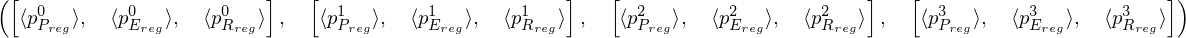

In [130]:
# Define the string for the states
p_reg = ['p_{P_{reg}}', 'p_{E_{reg}}', 'p_{R_{reg}}']

# Define the zeroth moments
p0_reg = [moment_sympy(x, 0) for x in p_reg]
# Define the first moments
p1_reg = [moment_sympy(x, 1) for x in p_reg]
# Define the second moments
p2_reg = [moment_sympy(x, 2) for x in p_reg]
# Define the second moments
p3_reg = [moment_sympy(x, 3) for x in p_reg]

p0_reg, p1_reg, p2_reg, p3_reg

In [131]:
# define "global" moments
mm0_reg = moment_sympy('\mathbf{m}_r', 0)
mm1_reg = moment_sympy('\mathbf{m}_r', None)
mm2_reg = moment_sympy('\mathbf{m}_r', 2)
pp0_reg = moment_sympy('\mathbf{p}_r', 0)
pp1_reg = moment_sympy('\mathbf{p}_r', None)
pp2_reg = moment_sympy('\mathbf{p}_r', 2)
mmpp_reg = moment_sympy('\mathbf{mp}_r', None)
mm0_reg, mm1_reg, mm2_reg, pp0_reg, pp1_reg, pp2_reg, mmpp_reg

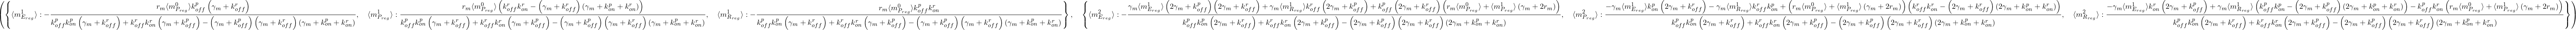

In [151]:
with open(tmpdir + 'three_state_mRNA_solutions.pkl', 'rb') as file:
    first_sol_reg_m = pickle.load(file)
    second_sol_reg_m = pickle.load(file)

first_sol_reg_m, second_sol_reg_m

Now we will define the state transition matrix $\mathbf{K}^r$, the mRNA production matrix $\mathbf{R}^r_m$ and the mRNA degradation matrix $\mathbf{\Gamma}^r_m$.

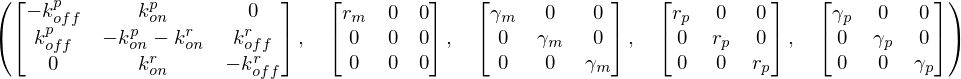

In [132]:
# Define the rate constant matrix
Km_reg = sympy.Matrix([[-kp_off, kp_on, 0], 
                         [kp_off, -(kp_on + kr_on), kr_off],
                         [0, kr_on, -kr_off]])
# Define the production matrix
Rm_reg = sympy.Matrix([[rm, 0, 0], 
                         [0, 0, 0],
                         [0, 0, 0]])
# Define the degradation matrix
Gm_reg = sympy.Matrix([[gm, 0, 0],
                         [0, gm, 0],
                         [0, 0, gm]])

# Define the production matrix
Rp_reg = sympy.Matrix([[rp, 0, 0], 
                         [0, rp, 0],
                         [0, 0, rp]])

# Define the production matrix
Gp_reg = sympy.Matrix([[gp, 0, 0], 
                         [0, gp, 0],
                         [0, 0, gp]])


Km_reg, Rm_reg, Gm_reg, Rp_reg, Gp_reg

### Zeroth moment three-state promoter
To solve the zeroth moment for the three-state promoter we use the same set of equations as for the two-state promoter, this is
$$
1 = \mathbf{u} \cdot \left\langle \mathbf{m}^0 \right\rangle,
$$
where this time $u = (1, 1, 1)$ and $\left\langle \mathbf{m}^0 \right\rangle$ is the vector containing all *three* states. We use as well
$$
\mathbf{0} = \mathbf{K}^r \left\langle \mathbf{m}^0 \right\rangle.
$$

We will again use the linear algebra solver where we write an extended matrix with the last column being the right hand side of these equations.

Let's now define this extended matrix.

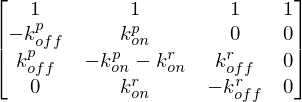

In [134]:
# Add the extra row for the normalization constraint
K_sys_reg = Km_reg.row_insert(0, sympy.Matrix([1, 1, 1]).transpose())

# Define right-side array
b = sympy.Matrix([1, 0, 0, 0])

# Define augmented matrix
zero_aug_reg = K_sys_reg.col_insert(3, b)
zero_aug_reg

Let's solve the system for our three zeroth moments.

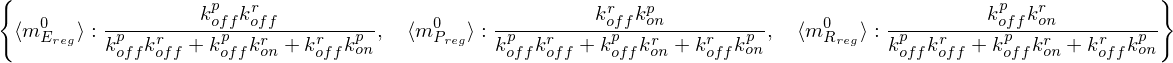

In [135]:
# Solve linear system for the three zeroth moments
zero_sol_reg = sympy.solve_linear_system(zero_aug_reg, *m0_reg)
zero_sol_reg

Let's quickly confirm that these moments add up to one since each represents the probability of being on each of the promoter states.

In [136]:
sum(zero_sol_reg.values()).simplify()

### First moment two-state promoter (protein)

Now that we have the zeroth moment that indicates the probability of being on either state let's now compute the first moment. For this we have the matrix equation
$$
\mathbf{0} = \left( \mathbf{K}^r - \mathbf{\Gamma}^r_p  \right)
             + \mathbf{R}^r_p \left\langle \mathbf{m} \right\rangle.
$$

Let's write this system in the form of the augmented matrix.

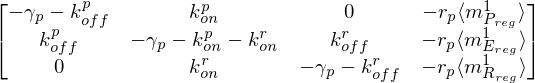

In [146]:
# Define augmented matrix for first moment
first_aug_reg = (Km_reg - Gp_reg).col_insert(3, 
                                            -Rp_reg * sympy.Matrix(m1_reg))
first_aug_reg

Now let's solve the system.

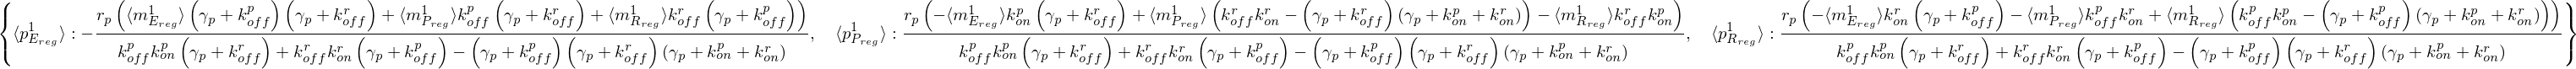

In [147]:
# Solve linear system for the three moments
first_sol_reg_p = sympy.solve_linear_system(first_aug_reg, *p1_reg)
first_sol_reg_p

Let's add all these first moments to obtain the complete distribution first moment.

In [150]:
first_reg_p = sum(first_sol_reg_p.values()).simplify()
first_reg_p_s = first_reg_p.subs(first_sol_reG_m)
first_reg_p, first_reg_p_s

NameError: name 'first_sol_reg_m' is not defined

#### fold-change.

A very relevant quantity to compute is the fold-change in gene expression. Since this quantity must be consistent between the thermodynamic framework and the master equation framework this quantity will constraint the value of the parameters that we obtain at the end of the day.

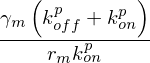

In [142]:
# Compute fold-change
fold_change = first_reg_p_s.subs(zero_sol_reg) / first_unreg_p_s
fold_change.factor(kr_off)

### Second moment three-state promoter

Finally for the second moment we have again an equation of the form
$$
\mathbf{0} = \left( \mathbf{K}^r_m - 2 \mathbf{\Gamma}^r_n \right) 
             \left\langle \mathbf{m}^2 \right\rangle
             + \left( 2 \mathbf{R}^r_m + \mathbf{\Gamma}^r_m \right)
             \left\langle \mathbf{m}^1 \right\rangle
             + \mathbf{R}^r_m
             \left\langle \mathbf{m}^0 \right\rangle
$$

Let's again define this augmented matrix.

In [ ]:
# Define augmented matrix for second moment
second_aug_reg = (2 * Gmat_reg - Kmat_reg).col_insert(3, 
                   (2 * Rmat_reg + Gmat_reg) * sympy.Matrix(m1_reg)\
                   + Rmat_reg * sympy.Matrix(m0_reg))
second_aug_reg

And now we solve the second moment.

In [ ]:
# Solve linear system for the three moments
second_sol_reg = sympy.solve_linear_system(second_aug_reg, *m2_reg)
second_sol_reg

Let's compute the global second moment adding all these second moments.

In [ ]:
second_reg = sum(second_sol_reg.values()).simplify()
second_reg.ratsimp()

In [ ]:
first_sol_reg[m1_reg[0]]

#### Noise and fano-factor.

Experimentally relevant quantities are the noise (standard deviation / mean) and the fano-factor (variance / mean). Let's compute these quantities for the three-state promoter.

First let's compute the variance.

In [ ]:
# Compute the variance for the three-state promoter
var_reg = (second_reg - first_reg**2)
var_reg_s = var_reg.subs(first_sol_reg).subs(zero_sol_reg).simplify()
var_reg.ratsimp(), var_reg_s.simplify()

Now the noise squared $\eta_{reg}$

In [ ]:
# Compute the noise-square for the three-state promoter
noise_square_reg = (var_reg / first_reg**2)
noise_square_reg.ratsimp()

And finally the fano-factor.

In [ ]:
first_sol_reg[m1_reg[0]] / first_reg.simplify()

In [ ]:
fano_reg = var_reg / first_reg
fano_reg_s = fano_reg.subs(first_sol_reg).subs(zero_sol_reg)
fano_reg.ratsimp(), fano_reg_s.simplify()

### Third moment three-state promoter

As an extra derivation we will include the 3rd moment in our calculation. This will be useful to define the equations to compute the parameters. The matrix equation for the 3rd moment is given by
$$
\mathbf{0} = \left( \mathbf{K}^r_m - 3 \mathbf{\Gamma}^r_n \right) 
             \left\langle \mathbf{m}^2 \right\rangle
             + \left( 3 \mathbf{R}^r_m + 3 \mathbf{\Gamma}^r_m \right)
             \left\langle \mathbf{m}^2 \right\rangle
             + \left( 3 \mathbf{R}^r_m - \mathbf{\Gamma}^r_m \right)
             \left\langle \mathbf{m}^1 \right\rangle
             + \mathbf{R}^r_m
             \left\langle \mathbf{m}^0 \right\rangle
$$

Let's again define this augmented matrix.

In [ ]:
# Define augmented matrix for third moment
third_aug_reg = (3 * Gmat_reg - Kmat_reg).col_insert(2, 
                  (3 * Rmat_reg + 3 * Gmat_reg) * sympy.Matrix(m2_reg)\
                  + (3 * Rmat_reg - Gmat_reg) * sympy.Matrix(m1_reg)
                  + Rmat_reg * sympy.Matrix(m0_reg))
third_aug_reg

In [ ]:
# Solve linear system for the three moments
third_sol_reg = sympy.solve_linear_system(third_aug_reg, *m3_reg)
third_sol_reg

In [ ]:
third_reg = sum(third_sol_reg.values()).simplify()
third_reg

In [ ]:
r1 = first_reg.subs(gm, 1).subs(zero_sol_reg).subs(gm, 1)
r1

In [ ]:
r2 = ((second_reg - first_reg) / first_reg).subs(gm, 1).\
     subs(first_sol_reg).subs(zero_sol_reg).subs(gm, 1).simplify()
r2

In [ ]:
r3 = ((third_reg - 3 * second_reg + 2 * first_reg) / \
     (second_reg - first_reg)).subs(second_sol_reg).subs(first_sol_reg).\
     subs(zero_sol_reg).subs(gm, 1).simplify()
r3

In [ ]:
x1, x2, x3 = sympy.symbols('r_1 r_2 r_3')
sympy.solve([r1 - x1, r2 - x2, r3 - x3], kr_off, kr_on)

In [ ]:
param_reg = sympy.solve([r1 - x1, r2 - x2], kr_off, kr_on)
param_reg

In [ ]:
(param_reg[kr_on] / param_reg[kr_off]).simplify().collect(kp_on / kp_off)